En este notebook se realiza un ejercicio de análisis, limpieza y preprocesado de un dataset, para la posterior búsqueda de un modelo de machine learning con el que predecir el valor de una variable del mismo dataset. 

Para el ejercicio, he usado el siguiente dataset: https://www.kaggle.com/datasets/mojtaba142/hotel-booking/data y he usado como variable objetivo `is_canceled`, que indica si una reserva en el hotel ha sido cancelada tras su reserva o no.

# 0 - Imports y funciones

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import joblib
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, recall_score, accuracy_score, precision_score, auc, roc_curve
from sklearn.feature_selection import SelectKBest

In [89]:
#Fijamos la semilla
seed = 12345 

In [90]:
def graficos_eda_categoricos(cat):
    
    #Calculamos el número de filas que necesitamos
    filas = ceil(cat.shape[1] / 2)

    #Definimos el gráfico
    f, ax = plt.subplots(nrows = filas, ncols = 2, figsize = (16, filas * 6))

    #Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat 

    #Creamos el bucle que va añadiendo gráficos
    for cada, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax = ax[cada])
        ax[cada].set_title(variable, fontsize = 12, fontweight = "bold")
        ax[cada].tick_params(labelsize = 12)

def graficos_eda_numericos(df):

    #Cogemos numero de columnas y creamos el gráfico con tantas 
    # filas como variables numéricas y dos columnas (una para el histograma y otra para el boxplot)
    n_cols = len(df.columns)
    fig, axes = plt.subplots(nrows=n_cols, ncols=2, figsize=(10, 5 * n_cols))  # Adjust size as necessary
    
    for i, column in enumerate(df.columns):
        #Histograma
        axes[i, 0].hist(df[column], bins=10, color='skyblue', edgecolor='black')
        axes[i, 0].set_title(f'Histograma de {column}')
        axes[i, 0].set_ylabel('Frecuencia')
        
        #Boxplot
        axes[i, 1].boxplot(df[column], vert=True, patch_artist=True, notch=True)
        axes[i, 1].set_title(f'Boxplot de {column}')
        axes[i, 1].set_ylabel('Valor')

In [91]:
#Función para mostrar los resultados
def boxplots_algorithms(results, names):
    
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

In [219]:
def variables_usadas(column_transformer, selector):

    #Sacar la mascara del selector
    mascara_variables = selector.get_support()

    #Sacar la codificacion de las variables (los nombre de las columnas)
    variables_sin_codificar = column_transformer.get_feature_names_out()

    #Devolver la lista resultante aplicando la mascara
    return variables_sin_codificar[mascara_variables]

In [281]:
def get_variable_name_from_sequence(sequence, variables):

    for original_var in variables:
        if original_var in sequence:
            return original_var

    #If no one was found, return None
    return None

El objetivo del ejercicio es analizar un dataset que contiene datos sobre clientes que se alojaron en un hotel (Resort). Para ello, usaremos un dataset con datos (119k registros) sobre el hotel objetivo (Resort) junto con otro hotel (city hotel), del cual eliminaremos sus registros.

Tras ello, buscar el mejor modelo que nos permita predecir, basado en unas features que elijamos, si el cliente va a cancelar su reserva o acudirá.

# 1 - Análisis exploratorio y procesado

## 1.1 - Carga

In [92]:
df_entrada = pd.read_csv("hotel_booking.csv")
df_entrada.head(6)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Jasmine Fletcher,JFletcher43@xfinity.com,190-271-6743,************9263


In [93]:
#Filtramos por el hotel que queremos analizar (Resort Hotel)
df = df_entrada.query("hotel == 'Resort Hotel'")
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.00,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,Resort Hotel,0,212,2017,August,35,31,2,8,2,...,Transient,89.75,0,0,Check-Out,2017-09-10,Willie Hamilton,Hamilton_Willie@mail.com,172-436-4780,************5145
40056,Resort Hotel,0,169,2017,August,35,30,2,9,2,...,Transient-Party,202.27,0,1,Check-Out,2017-09-10,Carrie Walker,Carrie_Walker@yahoo.com,141-149-4764,************9816
40057,Resort Hotel,0,204,2017,August,35,29,4,10,2,...,Transient,153.57,0,3,Check-Out,2017-09-12,Joshua Small,Joshua_Small@aol.com,769-653-1129,************7686
40058,Resort Hotel,0,211,2017,August,35,31,4,10,2,...,Contract,112.80,0,1,Check-Out,2017-09-14,Michele Hanson,MHanson@yahoo.com,670-269-4799,************8961


In [94]:
print(f"Tamaño del dataset: {df.shape}")

Tamaño del dataset: (40060, 36)


40.000 registros en total, con 36 variables. Vemos las columnas del dataset.

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40060 entries, 0 to 40059
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           40060 non-null  object 
 1   is_canceled                     40060 non-null  int64  
 2   lead_time                       40060 non-null  int64  
 3   arrival_date_year               40060 non-null  int64  
 4   arrival_date_month              40060 non-null  object 
 5   arrival_date_week_number        40060 non-null  int64  
 6   arrival_date_day_of_month       40060 non-null  int64  
 7   stays_in_weekend_nights         40060 non-null  int64  
 8   stays_in_week_nights            40060 non-null  int64  
 9   adults                          40060 non-null  int64  
 10  children                        40060 non-null  float64
 11  babies                          40060 non-null  int64  
 12  meal                            40060

## 1.2 - Nulos y eliminación de variables

Las variables `name`, `email`, `phone-number` y `credit_card` están enmascaradas por motivos de privacidad, además no nos pueden aportar ningún valor predictivo por lo tanto las eliminamos.

También la variable `arrival_date_year` la quitamos debido a que no tendría sentido entrenar un modelo con una variable que solo toma valores.

La variable `reservation_status` tiene una relación 1 a 1 con la variable objetivo, por lo que la quitamos también.

Finalmente, podemos quitar también la variable `hotel`, ya que diferenciaba entre los dos hoteles que había en el dataset, pero dado que ya hemos filtrado por uno de ellos, esa variable no nos aporta información.


In [96]:
#Comprobamos que, efectivamente la variable "arrival_date_year" solo tiene valores de años pasados
df["arrival_date_year"].unique()

array([2015, 2016, 2017], dtype=int64)

In [97]:
#Borramos las columnas indicadas
df = df.drop(columns = ["name", "email", "phone-number", "credit_card", "arrival_date_year", "hotel", "reservation_status"])
df

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,0,342,July,27,1,0,0,2,0.0,0,...,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,2015-07-01
1,0,737,July,27,1,0,0,2,0.0,0,...,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,2015-07-01
2,0,7,July,27,1,0,1,1,0.0,0,...,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,2015-07-02
3,0,13,July,27,1,0,1,1,0.0,0,...,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,2015-07-02
4,0,14,July,27,1,0,2,2,0.0,0,...,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,August,35,31,2,8,2,1.0,0,...,1,No Deposit,143.0,NaN,0,Transient,89.75,0,0,2017-09-10
40056,0,169,August,35,30,2,9,2,0.0,0,...,0,No Deposit,250.0,NaN,0,Transient-Party,202.27,0,1,2017-09-10
40057,0,204,August,35,29,4,10,2,0.0,0,...,0,No Deposit,250.0,NaN,0,Transient,153.57,0,3,2017-09-12
40058,0,211,August,35,31,4,10,2,0.0,0,...,0,No Deposit,40.0,NaN,0,Contract,112.80,0,1,2017-09-14


Vemos las columnas con algun nulo y el porcentaje de nulos de esa variable.

In [98]:
#Sacar columnas con nan y su porcentaje de nans
columnas_con_nan = df.columns[df.isna().any()].tolist()

#También añado las 
dict_nans = {
    "Columna" : columnas_con_nan,
    "Numero nan" : [df[name_col].isna().sum() for name_col in columnas_con_nan],
    "Porcentaje nan" : [df[name_col].isna().sum()/df[name_col].size for name_col in columnas_con_nan],
    "valores unicos" : [df[name_col].nunique() for name_col in columnas_con_nan]
}

#Mostrarlo en un dataframe
pd.DataFrame(dict_nans)

,Columna,Numero nan,Porcentaje nan,valores unicos
0,country,464,0.011583,125
1,agent,8209,0.204918,185
2,company,36952,0.922416,235


Las variable `company` tiene más del 90% de valores perdidos, por lo que no nos aporta mucha información. Representa a la compañía encargada de hacer la reserva. Los valores perdidos pueden ser porque la reserva la hizo un particlar (la mayoría de los casos), por lo tanto podemos crear una variable llamada `reserva_company` que nos idique si fué una compañía la que reservó o no.

Para `agent` pasa algo parecido, solo que hay más valores que en country. Por el momento, dejamos los nulos como "None" para poder realizar el análisis de frecuencias y luego decidiré si imputarlas o hacer algo parecido a la anterior variable. 

La variable `country` tiene muy pocos valores perdidos (1%), por lo que la imputaremos.

In [99]:
df_no_nulos = df.copy()

#Crear variable binaria alternativa a company y eliminar la primera
df_no_nulos["reserva_company"] = df_no_nulos["company"].apply(lambda x: "No" if np.isnan(x) else "Yes")
df_no_nulos = df_no_nulos.drop(columns = ["company"])

#Sustituimos "None" por los nulos en agent
df_no_nulos["agent"] = df_no_nulos["agent"].apply(lambda x: "None" if np.isnan(x) else str(x)) #Convertir a categórica, así la trataremos

#Imputamos por la moda en country
moda_country = df['country'].mode()[0]
df_no_nulos["country"].fillna(moda_country, inplace=True)
#Enseñamos el df
df_no_nulos.head(6)

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,reserva_company
0,0,342,July,27,1,0,0,2,0.0,0,...,3,No Deposit,None,0,Transient,0.0,0,0,2015-07-01,No
1,0,737,July,27,1,0,0,2,0.0,0,...,4,No Deposit,None,0,Transient,0.0,0,0,2015-07-01,No
2,0,7,July,27,1,0,1,1,0.0,0,...,0,No Deposit,None,0,Transient,75.0,0,0,2015-07-02,No
3,0,13,July,27,1,0,1,1,0.0,0,...,0,No Deposit,304.0,0,Transient,75.0,0,0,2015-07-02,No
4,0,14,July,27,1,0,2,2,0.0,0,...,0,No Deposit,240.0,0,Transient,98.0,0,1,2015-07-03,No
5,0,14,July,27,1,0,2,2,0.0,0,...,0,No Deposit,240.0,0,Transient,98.0,0,1,2015-07-03,No


## 1.3 - Corrección de tipos

In [100]:
#Enseñamos de nuevo las varaibles que quedan
df_no_nulos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40060 entries, 0 to 40059
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     40060 non-null  int64  
 1   lead_time                       40060 non-null  int64  
 2   arrival_date_month              40060 non-null  object 
 3   arrival_date_week_number        40060 non-null  int64  
 4   arrival_date_day_of_month       40060 non-null  int64  
 5   stays_in_weekend_nights         40060 non-null  int64  
 6   stays_in_week_nights            40060 non-null  int64  
 7   adults                          40060 non-null  int64  
 8   children                        40060 non-null  float64
 9   babies                          40060 non-null  int64  
 10  meal                            40060 non-null  object 
 11  country                         40060 non-null  object 
 12  market_segment                  40060

La variable `arrival_date_week_number` representa el número de semana dentro del año que llegaron los clientes. Así mismo como la variable `arrival_date_day_of_month` representa el día dentro del mes en el que llegan los turistas. Ambas deben ser tratados como variables categóricas y no como int (numericas).

La variable `children` es tipo float, cosa que no tiene sentido.

La variable `is_repeated_guest` parece una variable binaria.

Finalmente, la variable OBJETIVO `is_canceled` es una variable binaria, que toma el valor 0 si no se canceló y 1 si se canceló.

Vamos a verlo.

In [101]:
print(f"Categorias variable 'children': {df['children'].unique().tolist()}")
print(f"Categorias variable 'is_repeated_guest': {df['is_repeated_guest'].unique().tolist()}")
print(f"Categorias variable 'is_canceled': {df['is_canceled'].unique().tolist()}")

Categorias variable 'children': [0.0, 1.0, 2.0, 10.0, 3.0]
Categorias variable 'is_repeated_guest': [0, 1]
Categorias variable 'is_canceled': [0, 1]


La primera toma valores enteros codificados como decimales erróneamente. La segunda es una variable binaria que debería tratarse como categoría.

In [102]:
df_tipos_corregidos = df_no_nulos.copy()

#Corregir esos errores de tipos
df_tipos_corregidos = df_tipos_corregidos.astype({"arrival_date_week_number": str, "arrival_date_day_of_month": str,
                                                 "children": 'int64'})
df_tipos_corregidos["is_repeated_guest"] = df_tipos_corregidos["is_repeated_guest"].apply(lambda x: "Yes" if x == 1 else "No")
df_tipos_corregidos["is_canceled"] = df_tipos_corregidos["is_canceled"].apply(lambda x: "Yes" if x == 1 else "No")

In [103]:
#Vemos que están corregidos
df_tipos_corregidos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40060 entries, 0 to 40059
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     40060 non-null  object 
 1   lead_time                       40060 non-null  int64  
 2   arrival_date_month              40060 non-null  object 
 3   arrival_date_week_number        40060 non-null  object 
 4   arrival_date_day_of_month       40060 non-null  object 
 5   stays_in_weekend_nights         40060 non-null  int64  
 6   stays_in_week_nights            40060 non-null  int64  
 7   adults                          40060 non-null  int64  
 8   children                        40060 non-null  int64  
 9   babies                          40060 non-null  int64  
 10  meal                            40060 non-null  object 
 11  country                         40060 non-null  object 
 12  market_segment                  40060

Finalmente, separamos variables en Categóricas, Numércias y variable objetivo.

In [104]:
var_obj = df_tipos_corregidos["is_canceled"]
#De las variables categoricas, hay que quitar la variable objetivo
var_cat = df_tipos_corregidos.select_dtypes("O").drop(columns=["is_canceled"])
var_num = df_tipos_corregidos.select_dtypes(exclude="O")

## 1.4 - Análisis de categóricas

Para el análisis de categóricas, al ser solo 16 variables, haremos un análisis de frecuencias.

In [105]:
#Hacemos un describe
var_cat.describe().T

,count,unique,top,freq
arrival_date_month,40060,12,August,4894
arrival_date_week_number,40060,53,33,1197
arrival_date_day_of_month,40060,31,12,1577
meal,40060,5,BB,30005
country,40060,125,PRT,18094
market_segment,40060,6,Online TA,17729
distribution_channel,40060,4,TA/TO,28925
is_repeated_guest,40060,2,No,38282
reserved_room_type,40060,10,A,23399
assigned_room_type,40060,11,A,17046


Para evitar los gráficos en los que no se va a ver nada, filtramos y graficamos solo las variables con menos de 20 categorías. El resto veremos como se distribuyen las frecuencias de las categorías.

In [106]:
#Seleccionamos los que tengan menos que 20 variables para graficar, el resto lo haremos aparte
var_cat_less20 = var_cat[var_cat.columns[(var_cat.nunique() < 20)]]
var_cat_ge20 = var_cat[var_cat.columns[~(var_cat.nunique() < 20)]]

### Pocas categorías

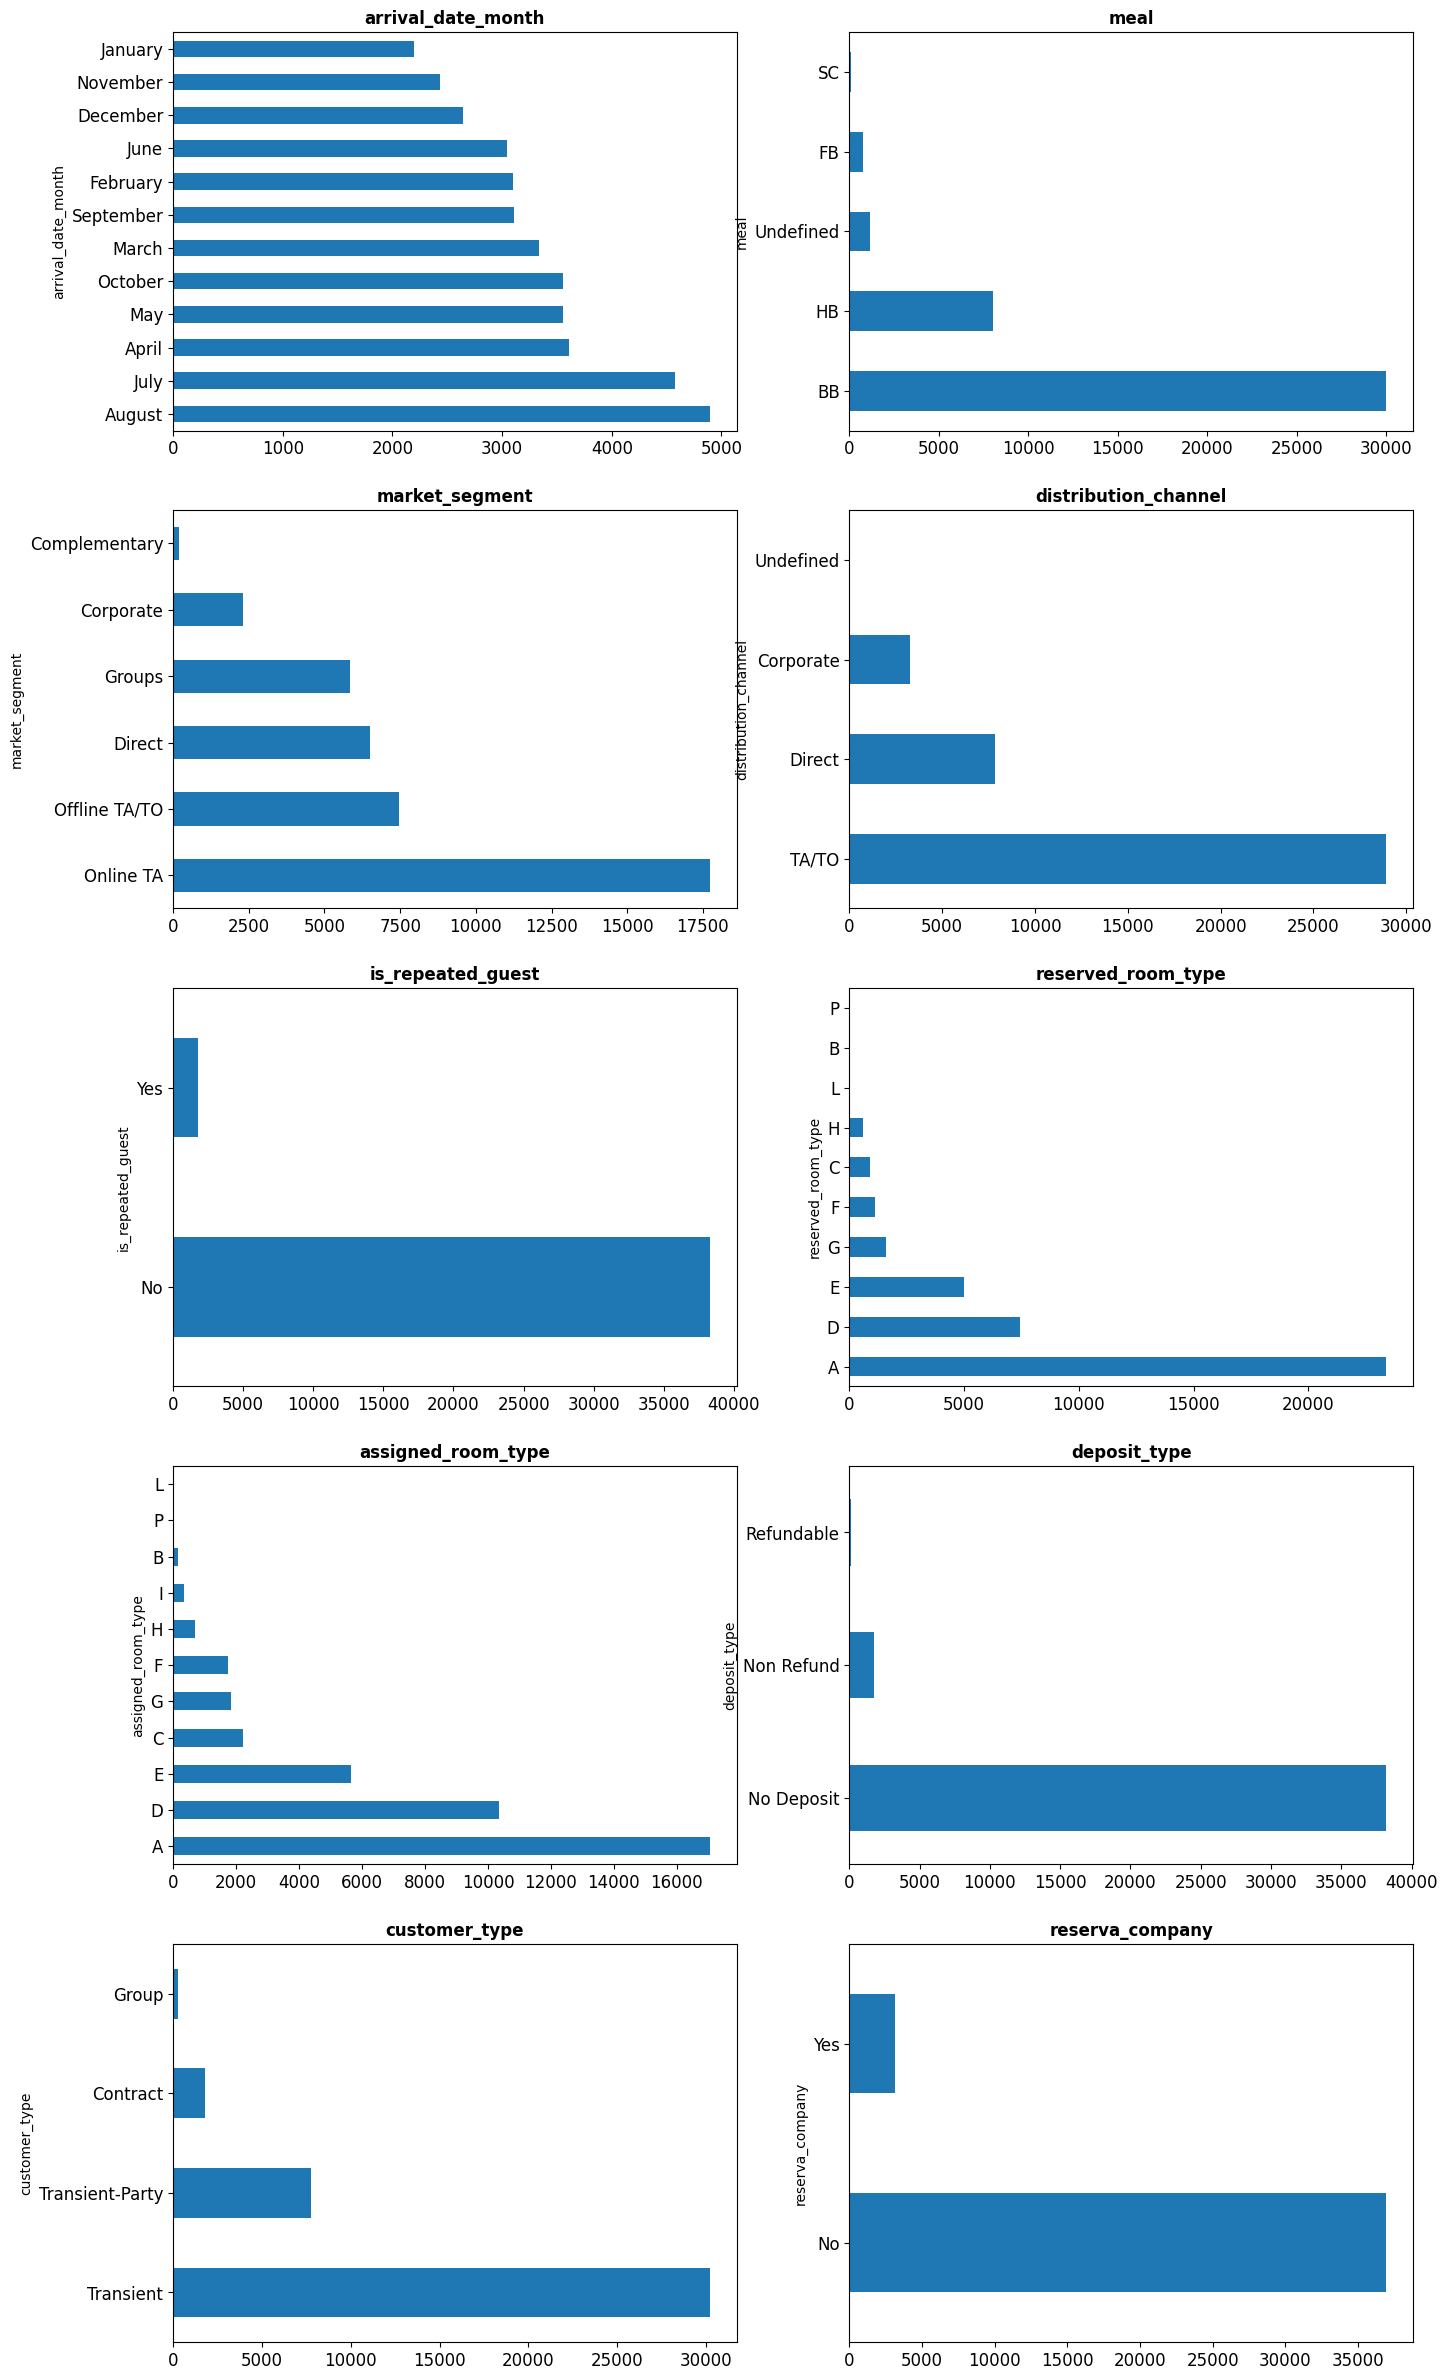

In [107]:
graficos_eda_categoricos(var_cat_less20)

Principalmente podemos ver que se pueden hacer dos cosas:

- `assigned_room_type` podemos juntar los tipos menos frecuentes (L, P, B, I, H)
- `reserved_room_type` lo mismo que la anterior

El resto de variables vemos que aunque haya alguna categoría minoritaria, el número de categorías es adecuado.

In [108]:
#Definir lista de categorias a juntar
categorias_a_juntar = ["L", "P", "B", "I", "H"]

#Transformar ambas series
var_cat_less20["assigned_room_type"] = var_cat_less20["assigned_room_type"].apply(lambda x: x if x not in categorias_a_juntar else "Others")
var_cat_less20["reserved_room_type"] = var_cat_less20["reserved_room_type"].apply(lambda x: x if x not in categorias_a_juntar else "Others")

#Comprobar resultados
nuevas_categorias1 = var_cat_less20["assigned_room_type"].value_counts().rename("assigned_room_type")
nuevas_categorias2 = var_cat_less20["reserved_room_type"].value_counts().rename("reserved_room_type")

pd.concat([nuevas_categorias1, nuevas_categorias2], axis=1)

,assigned_room_type,reserved_room_type
A,17046,23399
D,10339,7433
E,5638,4982
C,2214,918
G,1853,1610
F,1733,1106
Others,1237,612


### Muchas categorías

In [109]:
for col in var_cat_ge20.columns:
    print(f"Numero de categorías en variable {col}: {var_cat_ge20[col].nunique()}")

Numero de categorías en variable arrival_date_week_number: 53
Numero de categorías en variable arrival_date_day_of_month: 31
Numero de categorías en variable country: 125
Numero de categorías en variable agent: 186
Numero de categorías en variable reservation_status_date: 913


In [110]:
dfs = []
col_names = []

for col in var_cat_ge20.columns:
    #Ordenar categorías por porcentaje de frecuencia
    v_c = var_cat_ge20[col].value_counts(normalize=True, ascending=False)
    #Calcular el acumulado
    v_c_cs = v_c.cumsum()
    #Crear un nuevo dataframe
    df_props = pd.concat([v_c, v_c_cs], axis=1).reset_index()
    df_props.columns = ["categories", "percentage", "cum_percentage"]
    dfs.append(df_props)
    col_names.append(col)

result = pd.concat(dfs, axis=1, keys=col_names)
result.head(20)

arrival_date_week_number                            \
                 categories percentage cum_percentage   
0                        33   0.029880       0.029880   
1                        31   0.027484       0.057364   
2                        34   0.027209       0.084573   
3                        30   0.026860       0.111433   
4                        32   0.026311       0.137743   
5                        29   0.025886       0.163630   
6                        18   0.025262       0.188892   
7                        28   0.024663       0.213555   
8                        35   0.023739       0.237294   
9                        43   0.022891       0.260185   
10                       21   0.022616       0.282801   
11                       15   0.022616       0.305417   
12                        7   0.022566       0.327983   
13                       41   0.021393       0.349376   
14                       22   0.021193       0.370569   
15                       17   0.020969       0.391538   
16                       13   0.020245       0.411782   
17                       27   0.020220       0.432002   
18                        9   0.019845       0.451847   
19                       38   0.019321       0.471168   

   arrival_date_day_of_month                              country             \
                  categories percentage cum_percentage categories percentage   
0                         12   0.039366       0.039366        PRT   0.451672   
1                         30   0.036770       0.076136        GBR   0.170095   
2                          5   0.036445       0.112581        ESP   0.098777   
3                         16   0.035597       0.148178        IRL   0.054069   
4                          9   0.035047       0.183225        FRA   0.040215   
5                         26   0.034923       0.218148        DEU   0.030030   
6                         17   0.034798       0.252946         CN   0.017723   
7                          2   0.034648       0.287594        NLD   0.012831   
8                         18   0.034398       0.321992        USA   0.011957   
9                         24   0.034199       0.356191        ITA   0.011458   
10                        25   0.033375       0.389566        BEL   0.011183   
11                         3   0.033075       0.422641        CHE   0.010859   
12                        15   0.033000       0.455642        BRA   0.010734   
13                        19   0.032576       0.488218        POL   0.008313   
14                         4   0.032501       0.520719        SWE   0.007589   
15                         1   0.032302       0.553020        AUT   0.005242   
16                        28   0.031852       0.584873        RUS   0.004718   
17                        11   0.031752       0.616625        ROU   0.004418   
18                        22   0.031702       0.648328        FIN   0.003769   
19                        27   0.031578       0.679905        CHN   0.003345   

                       agent                            \
   cum_percentage categories percentage cum_percentage   
0        0.451672      240.0   0.347104       0.347104   
1        0.621767       None   0.204918       0.552022   
2        0.720544      250.0   0.071618       0.623640   
3        0.774613      241.0   0.042961       0.666600   
4        0.814828       40.0   0.025012       0.691613   
5        0.844858      314.0   0.023140       0.714753   
6        0.862581      242.0   0.019446       0.734199   
7        0.875412        6.0   0.015152       0.749351   
8        0.887369       96.0   0.013405       0.762756   
9        0.898827      243.0   0.012831       0.775587   
10       0.910010      298.0   0.011782       0.787369   
11       0.920869      171.0   0.009061       0.796430   
12       0.931603      273.0   0.008712       0.805142   
13       0.939915      177.0   0.008163       0.813305   
14       0.947504      196.0   0.007264       0.820569   
1

Las variables `arrival_date_week_number` y `arrival_date_day_of_month` tienen valores muy bien distribuidos en sus categorías y tenemos valores para todas las posibles categorías (53 posibles semanas al año y 31 días posibles al mes).

Las variable `country` tiene la mayoría de sus valores en las top 10 categorías (paises) y `agent` más o menos igual. Juntaremos de nuevo estas categorías minoritarias en una categoría "Others" para cada variable.

Finalmente, la variable `reservation_status_date` indica la fecha de última actuaización del estado de la reserva. Ya que no tenemos otra fecha con la que comparar, no podremos extraer mucha información de esta variable, por lo que se deshecha.

Aplicamos las transformaciones

In [111]:
#Cogemos las listas de las categorias a mantener
top_10_country = var_cat_ge20["country"].value_counts(ascending=False)[:10].index.tolist()
top_10_agent = var_cat_ge20["agent"].value_counts(ascending=False)[:10].index.tolist()

#Actualizamos las columnas
var_cat_ge20["country"] = var_cat_ge20["country"].apply(lambda x: x if x in top_10_country else "Others")
var_cat_ge20["agent"] = var_cat_ge20["agent"].apply(lambda x: x if x in top_10_agent else "Others")

#Comprobar resultados
nuevas_categorias1 = var_cat_ge20["country"].value_counts().rename("country")
nuevas_categorias2 = var_cat_ge20["agent"].value_counts().rename("agent")

display(pd.DataFrame(nuevas_categorias1))
display(pd.DataFrame(nuevas_categorias2))

,country
country,
PRT,18094
GBR,6814
Others,4053
ESP,3957
IRL,2166
FRA,1611
DEU,1203
CN,710
NLD,514


,agent
agent,
240.0,13905
Others,8990
None,8209
250.0,2869
241.0,1721
40.0,1002
314.0,927
242.0,779
6.0,607


In [112]:
#Quitamos la variable reservation_status_date
var_cat_ge20 = var_cat_ge20.drop(columns = ["reservation_status_date"])

### Juntar ambos dataframes de nuevo

In [113]:
var_cat = pd.concat([var_cat_ge20, var_cat_less20], axis=1)
var_cat

,arrival_date_week_number,arrival_date_day_of_month,country,agent,arrival_date_month,meal,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,deposit_type,customer_type,reserva_company
0,27,1,PRT,None,July,BB,Direct,Direct,No,C,C,No Deposit,Transient,No
1,27,1,PRT,None,July,BB,Direct,Direct,No,C,C,No Deposit,Transient,No
2,27,1,GBR,None,July,BB,Direct,Direct,No,A,C,No Deposit,Transient,No
3,27,1,GBR,Others,July,BB,Corporate,Corporate,No,A,A,No Deposit,Transient,No
4,27,1,GBR,240.0,July,BB,Online TA,TA/TO,No,A,A,No Deposit,Transient,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,35,31,GBR,Others,August,BB,Offline TA/TO,TA/TO,No,A,A,No Deposit,Transient,No
40056,35,30,IRL,250.0,August,BB,Direct,Direct,No,E,E,No Deposit,Transient-Party,No
40057,35,29,IRL,250.0,August,BB,Direct,Direct,No,E,E,No Deposit,Transient,No
40058,35,31,GBR,40.0,August,HB,Offline TA/TO,TA/TO,No,D,D,No Deposit,Contract,No


## 1.5 - Análisis de numéricas

In [114]:
#Empezamos con un describe
var_num.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,40060.0,92.675686,97.285315,0.00,10.0,57.0,155.0,737.0
stays_in_weekend_nights,40060.0,1.189815,1.147812,0.00,0.0,1.0,2.0,19.0
stays_in_week_nights,40060.0,3.128732,2.461329,0.00,1.0,3.0,5.0,50.0
adults,40060.0,1.867149,0.697285,0.00,2.0,2.0,2.0,55.0
children,40060.0,0.128682,0.445195,0.00,0.0,0.0,0.0,10.0
babies,40060.0,0.013904,0.118998,0.00,0.0,0.0,0.0,2.0
previous_cancellations,40060.0,0.101722,1.335115,0.00,0.0,0.0,0.0,26.0
previous_bookings_not_canceled,40060.0,0.146455,1.001955,0.00,0.0,0.0,0.0,30.0
booking_changes,40060.0,0.287968,0.726548,0.00,0.0,0.0,0.0,17.0
days_in_waiting_list,40060.0,0.527758,7.428580,0.00,0.0,0.0,0.0,185.0


No parece haber nada que desentone excepto la variable `adr` (Average Daily Rate - calculado dividiendo la suma de todas las transacciones de alojamiento por el número total de noches de estadía) tiene un mínimo menor que cero, lo cual supuestamente eso no es posible.

In [115]:
#Vemos cuantos registros tiene un valor menor que 0
(var_num["adr"] < 0).sum()

1

In [116]:
#Al ser solo uno, suponemos que es un error y eliminamos el registro
var_num = var_num[~(var_num["adr"] < 0)]
var_num.shape

(40059, 13)

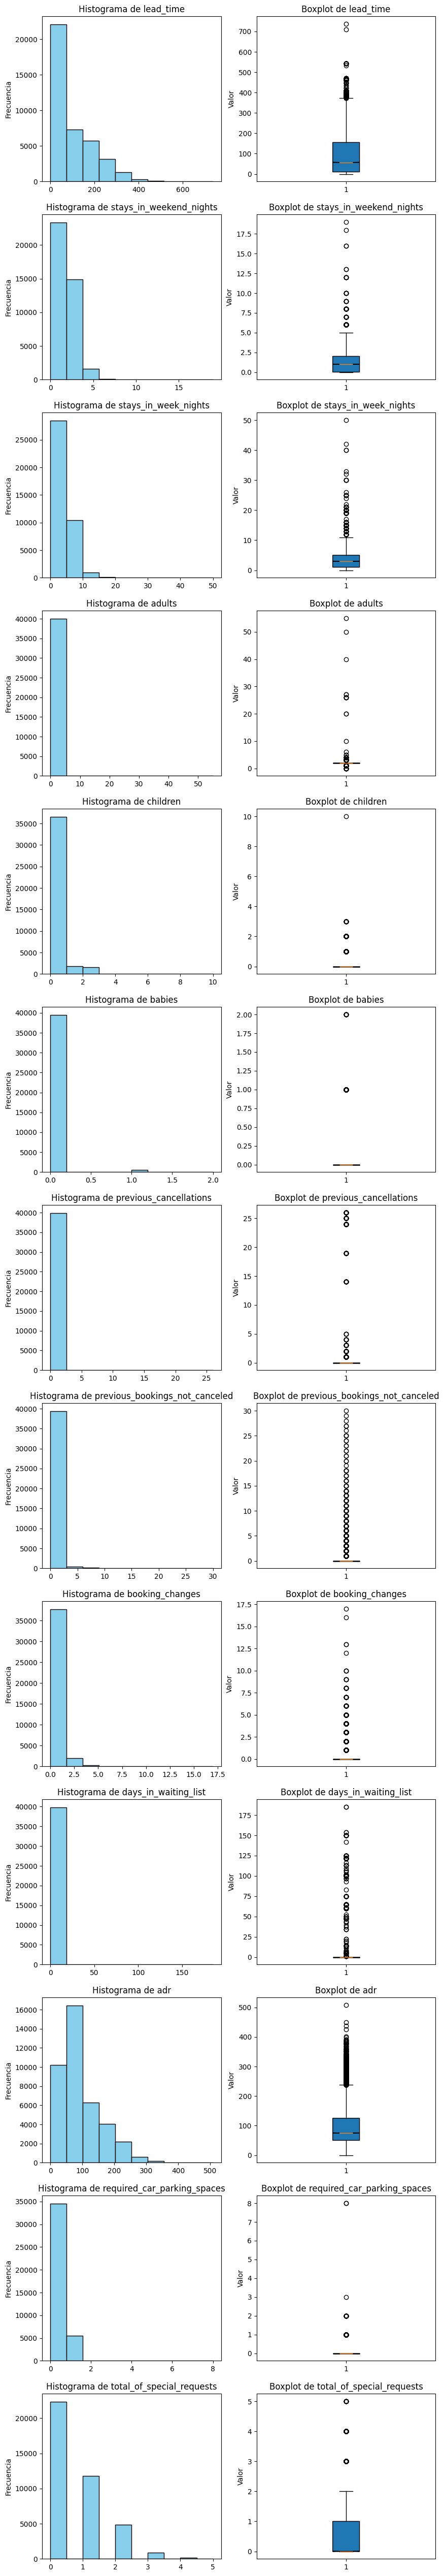

In [117]:
graficos_eda_numericos(var_num)

Todas las variables están altamente sesgadas hacia la derecha, y tienen bastantes valores atípicos, aunque los que se van mucho del rango intercuartil son variables como `stay_in_weekend_days` o `adults` que están en valores muy acotados, apenas llegando a llevarse uno o dos ordenes de magnitud, por lo que no aplicaremos logaritmo sobre ellas. 

Sin embargo, hay algunas variables como `babies`, `children`, `previous_cancellations` y `required_car_parking_spaces` que tendría mucho más sentido cambiarlas por una variable binaria en cada caso, ya que hay muy pocos valores que sean distintos a 0. Vamos a hacer los cambios.

In [118]:
#Definimos las variables a binarizar
numericas_a_binarias = ["babies", "children", "required_car_parking_spaces", "previous_cancellations"]

#Aplicar las transformaciones
for col in numericas_a_binarias:
    var_num[col] = var_num[col].apply(lambda x: "Yes" if x > 0 else "No")

#Comprobar los resultados
var_num[numericas_a_binarias].describe().T

,count,unique,top,freq
babies,40059,2,No,39511
children,40059,2,No,36575
required_car_parking_spaces,40059,2,No,34569
previous_cancellations,40059,2,No,38964


## 1.6 - Variable objetivo

Veremos la distribución de la variable objetivo.

In [119]:
var_obj.value_counts(normalize=True)

is_canceled
No     0.722366
Yes    0.277634
Name: proportion, dtype: float64

Hay un balance del 70/30 en la variable objetivo, lo cual no es mucho desbalanceo, considerando la naturaleza de los datos (es más normal no cancelar un viaje, o eso dice la logica al menos).

No obstante evaluaremos el modelo a usar teniendo esto en cuenta.

## 1.7 - Juntar todos los datasets procesados

Antes de juntar ambos datasets, hay que recordar que borramos del dataset de NUMERICAS un registro, que sigue teniendo valores en el dataset de categóricas. Quedarán nulos al juntarse que habrá que eliminar. También hab´ra que eliminar este índice de la variable objetivo

In [120]:
#Juntamos las variables predictoras en un DF y la variable objetivo la pasamos a numérica (0 - 1)
X = pd.concat([var_cat, var_num], axis=1)
y = var_obj.apply(lambda x: 0 if x == "No" else 1)

#Cogemos los nombres de las columnas tanto categóricas como numéricas
categorical_vars = X.select_dtypes("O").columns.tolist()
numerical_vars = X.select_dtypes(exclude="O").columns.tolist()

In [121]:
#Eliminamos el registro que borramos al analizar las numéricas que se quedó con NaNs al juntar los dataframes
index_nan = X[X.isna().any(axis=1)].index
X = X.drop(index_nan).reset_index(drop=True)
y = y.drop(index_nan).reset_index(drop=True)

#Checkear los tamaños
print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (40059, 27)
y: (40059,)


# 2 - Modelaje

## 2.1 - Preparación de los datos para el modelo

Para probar los distintos modelos, definiremos un transformados para las variables predictoras. Hará lo siguiente:

- Numéricas: Escalar las variables entre 0 y 1. Podríamos estandarizar pero prefiero escalar para evitar perder la distribución original.
- Categóricas: One Hot Encodig. Para ello, nos hemos asegurado que no haya variables con muchisimas categorías que generaran muchas variables al codificar en one hot
- Categóricas (2): Las variables `arrival_date_week_number` y `arrival_date_day_of_month` si que nos gustaría preservar el orden, ya que si representa información en este caso. Por lo tanto para ellas usaremos un Label Encoder. Aunque a efectos prácticos sería lo mismo que pasarlas a enteros, por lo que las convertiremos y añadiremos a la lista de numéricas.

In [122]:
X = X.astype({"arrival_date_week_number": "int64", "arrival_date_day_of_month" : "int64"})

#Actualizar las listas de nombres de variables
categorical_vars = X.select_dtypes("O").columns.tolist()
numerical_vars = X.select_dtypes(exclude="O").columns.tolist()

In [123]:
#Creamos las instancias
ohe = OneHotEncoder(drop="first")
scaler = MinMaxScaler()

#Crear el column transformer para poder ser usado más tarde en el pipeline.
c_transf = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe, categorical_vars),
        ("MinMaxScaler", scaler, numerical_vars)
    ],
    remainder="passthrough"
)

## 2.2 - Búsqueda del mejor modelo

Para esta parte, buscaremos, probando distintos modelos, el que mejor funcione para nuestro caso. Harémos un bucle iterando sobre distintos modelos, sacando sus scores para distintos splits de train/test utilizando un KFold de sklearn.

Como medida a usar en el cross_validation usaremos el f1_score, buscando la armonía entre precision y recall.

In [132]:
#Creamos la lista con los distintos modelos a probar
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('BC', BaggingClassifier()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC()))
models.append(('GBC', GradientBoostingClassifier(random_state=seed)))

Curren iteration: LR
Curren iteration: DTC
Curren iteration: BC
Curren iteration: KNC
Curren iteration: RFC
Curren iteration: SVM
Curren iteration: GBC


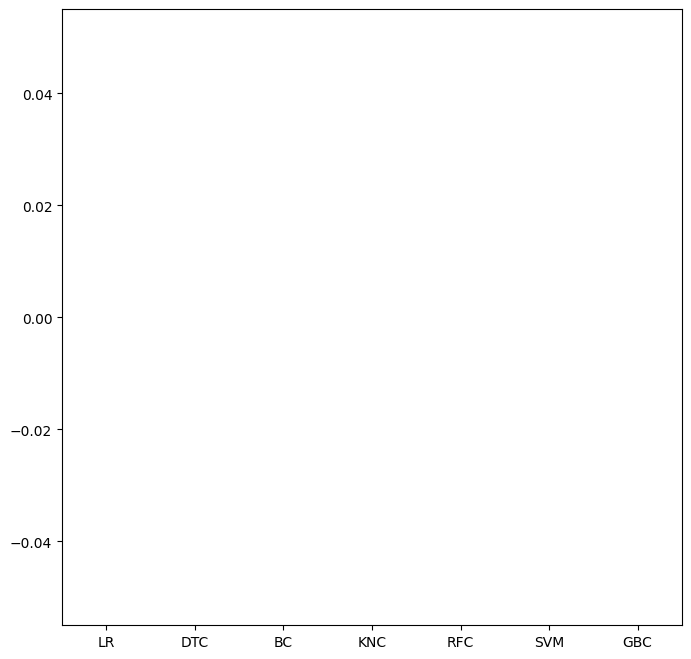

In [130]:
#Iteramos y vamos sacando los resultados
results = []
names = []

#Para cada modelo
for name, model in models:

    print(f"Curren iteration: {name}")
    
    #Crear el pipeline con el column transformer
    # y el modelo a usar
    pipeline = Pipeline(
        [
            ("ColumnTransformer", c_transf),
            (name,model)
        ]
    )

    #Crear la cross validation
    result_cv = cross_val_score(estimator=pipeline, X=X, y=y, scoring=make_scorer(f1_score), cv=KFold(n_splits=10, shuffle=True, random_state=seed))

    #Añadir los resultados
    results.append(result_cv)
    names.append(name)

#Limpiamos los resultados
results_clean = []
for r in results:
    results_clean.append([element for element in r if ~np.isnan(element)])

boxplots_algorithms(results_clean, names)

En el gráfico podemos ver que tanto en f1_score como en variabilidad en los resultados, el RandomForestClassifier gana al resto. Por lo tanto, usaremos ese modelo para nuestro problema. Ahora pasaremos a buscar la mejor parametrización y número de variables

## 2.3 - Selección de la mejor parametrización

El siguiente paso una vez elegido el modelo, es buscar los parámetros óptimos y el número óptimo de variables. Idealmente, queremos el mejor modelo con la menos cantidad de variables posibles.

Tenemos dos opciones para realizar la búsqueda:

- Crear un único grid_search con hyperparámetros para el SelectKBest (k, el número de variables) y para el algoritmo.
- Crear un bucle donde iteremos sobre los distintos valores que queremos probar de K y dentro hacer un grid_search tuneando únicamente los parámetros del algoritmo a probar.

Obtaré por la segunda ya que así puedo comparar los best_estimators para cada valor de K.

In [150]:
#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [203]:
model_name = "RFC"
model = RandomForestClassifier(random_state=seed)
k_values = [5,8,10,13,16]

scoring = {
    "auc": "roc_auc", 
    "accuracy": "accuracy",
    "f1_score": make_scorer(f1_score),
    "recall": make_scorer(recall_score),
    "precision": make_scorer(precision_score)
}

grid_searchs = []

#Iteramos sobre los distintos valores de K
for k_params in k_values:

    print(f"n_params: {k_params}")
    
    #Create the current iteration model name
    curr_model_name = model_name+ "_" + str(k_params)

    #Crear el pipeline
    pipeline = Pipeline([
        ("ColumnTransformer", c_transf),
        ("SelectKBest", SelectKBest(k=k_params)),
        (curr_model_name, model)
    ])
    
    #Definir los parámetros a usar
    param_grid = {
        curr_model_name + "__n_estimators" : [7,20,30,60],
        curr_model_name + "__criterion" : ['gini','entropy'],
        curr_model_name + "__max_depth" : [4,7,12,15],
        curr_model_name + "__min_samples_split" : [20, 40, 60, 100],
        curr_model_name + "__bootstrap" : [True, False]
    }

    #Crear el grid search y entrenarlo
    grid_model = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=seed),
        scoring=scoring,
        refit="auc"
    )

    grid_model.fit(X_train, y_train)

    #Añadir a la lista de resultados junto con su k asociada
    grid_searchs.append((k_params, grid_model))

n_params: 5


KeyboardInterrupt: 

In [309]:
#Guardar los resultados
with open("grid_search_results", "wb") as fp:
    pickle.dump(grid_searchs, fp)

In [204]:
#Descomentar para leer
with open("grid_search_results", "rb") as fp:
    grid_searchs = pickle.load(fp)

## 2.4 - Evaluación del modelo elegido

Ahora vamos a comprar los resultados de el mejor modelo para cada k. Para ello, cogeremos el best_estimator de cada iteración del bucle, y miraremos las siguientes medidas:

- Curva ROC con punto de corte óptimo
- AUC

Empezaremos con ellas por dos razones: primero porque hemos hecho el GridSearch de tal forma que nos puntúe los modelos por el AUC, por lo que en un primer paso hay que discriminar por estas medidas. Segundo, porque convendría encontrar el punto de corte óptimo para posteriormente analizar el resto de métricas, a saber:

- Accuracy
- Recall
- Precision
- F1

Como medidas para entender como de bien clasifica el mocelo y si falla o es mejor identificando una clase que otra, o si por el contrario identifica ambas clases con la misma precision (para eso la precision, recall y F1).

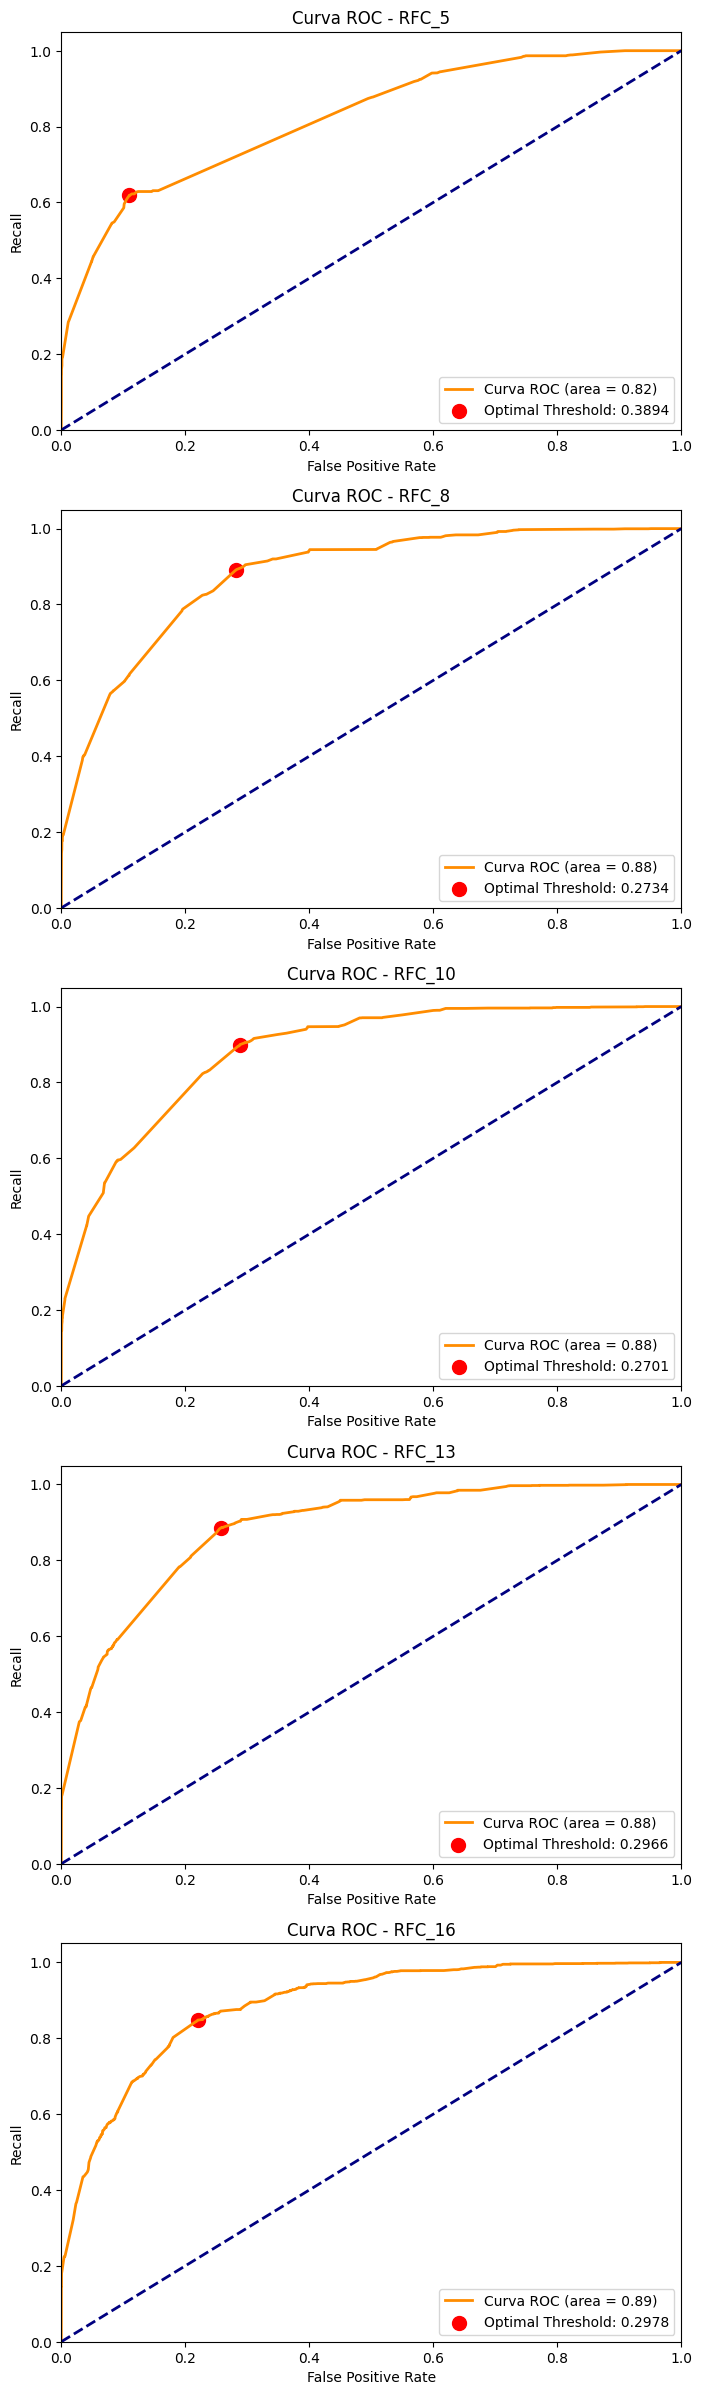

In [214]:
#Cogemos los best_estimators para cada K y sus nombres
modelos = [gs[1].best_estimator_ for gs in grid_searchs]
names = [gs[0] for gs in grid_searchs]
thresholds_optimos = []

#Definimos el gráfico
filas = len(names)
f, ax = plt.subplots(nrows = filas, ncols = 1, figsize = (8, filas * 6))
ax = ax.flat

#Iteramos a través de los modelos
for idx, (modelo, nombre) in enumerate(zip(modelos, names)):
    #Calculamos las probabilidades
    y_probs = modelo.predict_proba(X_test)[:, 1]

    # Calcula la curva ROC y el área bajo la curva (AUC)
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Encontramos el punto de corte óptimo
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    #Añadir a la lista
    thresholds_optimos.append(optimal_threshold)

    #Graficamos la curva roc, el AUC y el punto de corte óptimo
    ax[idx].plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
    ax[idx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[idx].scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {round(optimal_threshold,4)}', s=100)
    ax[idx].set_xlim([0.0, 1.0])
    ax[idx].set_ylim([0.0, 1.05])
    ax[idx].set_xlabel('False Positive Rate')
    ax[idx].set_ylabel('Recall')
    ax[idx].set_title(f'Curva ROC - RFC_{nombre}')
    ax[idx].legend(loc='lower right')

plt.show()

Podemos ver dos cosas:

- El punto de corte ideal para todos los modelos no está ni cerca de 0.5, por lo qe habría que tener cuidado al usar las clases de sklearn ya que suponen por defecto un punto de corte del 0.5, lo cual nos haría perder calidad del modelo.
- Salvo para k=5, en cuyo caso el AUC es de 0.82, para el resto de modelos vemos que aumentar las variables no aumenta apenas el AUC (0.88). Por lo tanto, con el objetivo de simplificar lo máximo posible el modelo, vamos a usar k=8.

Ahora, vamos a comprobar el resto de métricas teniendo en cuenta este punto de corte óptimo.

In [218]:
thresholds_optimos

[0.38943178552788804,
 0.2734345353566539,
 0.2700507695479459,
 0.2965803252677466,
 0.2978317074149076]

In [217]:
for modelo, nombre, threshold in zip(modelos, names, thresholds_optimos):
    #Calculamos las probs
    y_probs = modelo.predict_proba(X_test)[:, 1]
    #Usamos el punto de corte optimo sobre esas probs para sacar las preeicciones
    y_pred = (y_probs >= threshold).astype(int)
    #Enseñamos las metricas
    print(f"Modelo: RFC_{nombre}:")
    print(f"Accuracy -> {accuracy_score(y_true=y_test, y_pred=y_pred)}")
    print(f"Precision -> {precision_score(y_true=y_test, y_pred=y_pred)}")
    print(f"Recall -> {recall_score(y_true=y_test, y_pred=y_pred)}")
    print(f"F1 score -> {f1_score(y_true=y_test, y_pred=y_pred)}")
    print("------------------")

Modelo: RFC_5:
Accuracy -> 0.8145282076884673
Precision -> 0.6863230921704658
Recall -> 0.6188561215370867
F1 score -> 0.6508458646616543
------------------
Modelo: RFC_8:
Accuracy -> 0.7666000998502247
Precision -> 0.550828729281768
Recall -> 0.8909740840035746
F1 score -> 0.6807784226698531
------------------
Modelo: RFC_10:
Accuracy -> 0.7642286570144783
Precision -> 0.547431367219353
Recall -> 0.8999106344950849
F1 score -> 0.680750380260267
------------------
Modelo: RFC_13:
Accuracy -> 0.782326510234648
Precision -> 0.5711405529953917
Recall -> 0.886058981233244
F1 score -> 0.6945709281961471
------------------
Modelo: RFC_16:
Accuracy -> 0.7988017973040439
Precision -> 0.5987381703470032
Recall -> 0.8480786416443253
F1 score -> 0.7019230769230769
------------------


Vemos que todos los modelos tienden a discriminar bien quien no va a cancelar la reserva (Recall es siempre mayor al 80%) pero clasifican a muchos que no iban a cancelar como cancelados (precision ronda poco mas del 50%). Vamos a ver si podemos mejorar esto repitiendo el grid search sobre el modelo elegido, el de k=8.

## 2.5 - Refinamiento del modelo y selección de variables

Para la tarea, primero vamos a ver dos cosas:

- Las variables usadas por ese modelo
- Los parámetros elegidos en el grid_search

In [225]:
#Saco las variables seleccionadas
modelo_elegido = next((tupla for tupla in grid_searchs if tupla[0] == 8), None)[1]
variables_usadas(modelo_elegido.best_estimator_.steps[0][1],modelo_elegido.best_estimator_.steps[1][1])

array(['OneHotEncoder__country_GBR', 'OneHotEncoder__country_PRT',
       'OneHotEncoder__market_segment_Direct',
       'OneHotEncoder__market_segment_Online TA',
       'OneHotEncoder__deposit_type_Non Refund',
       'OneHotEncoder__previous_cancellations_Yes',
       'OneHotEncoder__required_car_parking_spaces_Yes',
       'MinMaxScaler__lead_time'], dtype=object)

In [227]:
#Parámetros
modelo_elegido.best_params_

{'RFC_8__bootstrap': True,
 'RFC_8__criterion': 'gini',
 'RFC_8__max_depth': 4,
 'RFC_8__min_samples_split': 20,
 'RFC_8__n_estimators': 20}

Sacamos esas variables como nuestras variables predictoras, y entrenamos el modelo de nuevo probando distinta prametrización. Vemos adeás que al final solo necesitaremos 6 variables, ya que de esas 8 mejores variables, 4 de ellas provienen de 2 variables solo, a causa del OneHotEncoder. Por lo que obtendremos un modelo usando solo 6 de las variables originales

In [232]:
variables_modelo_cat = ["country", "market_segment", "deposit_type", "previous_cancellations", "required_car_parking_spaces"]
variables_modelo_num = ["lead_time"]
variables_modelo = variables_modelo_cat + variables_modelo_num
X_model = X[variables_modelo]

#Creamos una nueva semilla
seed_2 = 98765

#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state=seed_2)

#Re-definimos el column transformer para que solo use nuestras variables
c_transf = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe, variables_modelo_cat),
        ("MinMaxScaler", scaler, variables_modelo_num)
    ],
    remainder="passthrough"
)

#El moelo a usar, con el pipeline (sin el selectkbest)
pipeline = Pipeline([
    ("ColumnTransformer", c_transf),
    ("RFC", RandomForestClassifier(random_state=seed_2))
])

#Definimos los parámetros del grid search
param_grid = {
    "RFC__n_estimators" : [4, 8, 15, 100, 200],
    "RFC__criterion" : ['gini','entropy'],
    "RFC__max_depth" : [3,4,5,7,10],
    "RFC__min_samples_split" : [20, 40, 60, 100],
    "RFC__bootstrap" : [True, False]
}

#El grid_search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=4,shuffle=True,random_state=seed),
    scoring="f1_macro", #Esta vez udaremos el f1 como medida de scoring
    verbose=True
)

#Entrenar
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('ColumnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('OneHotEncoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['country',
                                                                          'market_segment',
                                                                          'deposit_type',
                                                                          'previous_cancellations',
                                                                          'required_car_parking_spaces']),
                                                                        ('MinMaxScaler',
                                                                         MinMaxScaler(),
                                                                         ['lead_time'])])),
                                       ('RFC',
                                        RandomForestClassifier(random_state=98765))]),
             param_grid={'RFC__bootstrap': [True, False],
                         'RFC__criterion': ['gini', 'entropy'],
                         'RFC__max_depth': [3, 4, 5, 7, 10],
                         'RFC__min_samples_split': [20, 40, 60, 100],
                         'RFC__n_estimators': [4, 8, 15, 100, 200]},
             scoring='f1_macro', verbose=True)

Volvemos a hacer lo mismo de antes, ver su curva_roc, su AUC y sus otras medidas

[]

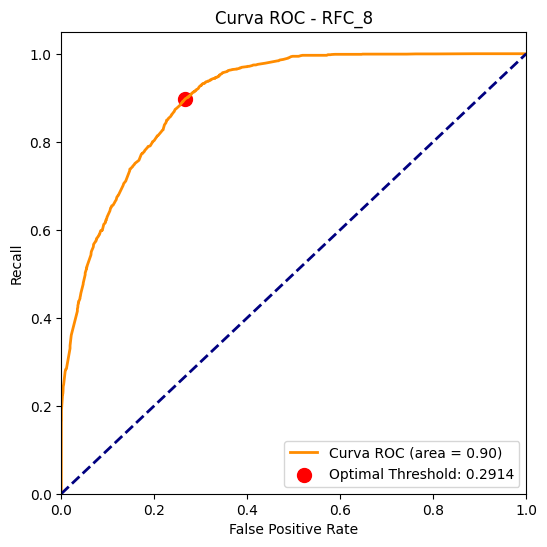

In [248]:
#Cogemos el modelo
modelo = grid_search.best_estimator_

#Calculamos las probabilidades
y_probs = modelo.predict_proba(X_test)[:, 1]

# Calcula la curva ROC y el área bajo la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Encontramos el punto de corte óptimo
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

#Graficamos la curva roc, el AUC y el punto de corte óptimo
f, ax = plt.subplots(figsize=(6,6))

ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {round(optimal_threshold,4)}', s=100)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Recall')
ax.set_title(f'Curva ROC - RFC_8')
ax.legend(loc='lower right')
plt.plot()

In [247]:
#Y las métricas
#Calculamos las probs
y_probs = modelo.predict_proba(X_test)[:, 1]
#Usamos el punto de corte optimo sobre esas probs para sacar las preeicciones
y_pred = (y_probs >= optimal_threshold).astype(int)
#Enseñamos las metricas
print(f"Modelo: RFC_8:")
print(f"Accuracy -> {accuracy_score(y_true=y_test, y_pred=y_pred)}")
print(f"Precision -> {precision_score(y_true=y_test, y_pred=y_pred)}")
print(f"Recall -> {recall_score(y_true=y_test, y_pred=y_pred)}")
print(f"F1 score -> {f1_score(y_true=y_test, y_pred=y_pred)}")

Modelo: RFC_8:
Accuracy -> 0.7789565651522716
Precision -> 0.5652296421527191
Recall -> 0.8979409131602507
F1 score -> 0.6937575652775376


**IMPORTANTE** Queda ver si la diferencia se puede producir por un sobreajuste a los datos de train, por lo tanto vamos a comprobarlo.

In [246]:
##Mismo procedimiento
y_probs = modelo.predict_proba(X_train)[:, 1]

y_pred = (y_probs >= optimal_threshold).astype(int)

print(f"Modelo: RFC_8:")
print(f"Accuracy -> {accuracy_score(y_true=y_train, y_pred=y_pred)}")
print(f"Precision -> {precision_score(y_true=y_train, y_pred=y_pred)}")
print(f"Recall -> {recall_score(y_true=y_train, y_pred=y_pred)}")
print(f"F1 score -> {f1_score(y_true=y_train, y_pred=y_pred)}")

Modelo: RFC_8:
Accuracy -> 0.782600555434206
Precision -> 0.5675504606512413
Recall -> 0.9079657965796579
F1 score -> 0.6984896351754879


No hay apenas diferencia entre train y test, es decir, no hay sobreajuste y por lo tanto suponemos que con las pruebas en test así es como el modelo actuaría en datos nuevos.

Podemos concluir que nuestro modelo:

- Identifica muy bien aquellos que cancelaron (clase 1) por su recall tan alta
- Sin embargo, esto lo hace a costa de sobreestimarla, produciento también muchos falsos positivos, es decir, personas que no cancelarían se clasifican como si cancelarán.

Nos quedaremos con este modelo, ya que obtenemos una accuracy global del 78% que no está mal, y además hemos conseguido un modelo que funciona solo con 6 variables. Dependiendo de la necesidad del modelo y la tarea para la cual se usará, convendría ajustar más, o probar otros modelos o usar como métrica selectora otra....

In [249]:
grid_search.best_params_

{'RFC__bootstrap': True,
 'RFC__criterion': 'entropy',
 'RFC__max_depth': 10,
 'RFC__min_samples_split': 20,
 'RFC__n_estimators': 8}

Por lo tanto, el algoritmo a usar será un RandomForestClassifier con semilla `seed_2` (98765) y los parámetros a usar serán:

- bootstrap = `True`
- criterion = `entropy`
- max_depth = `10`
- min_samples_split = `20`
- n_estimators = `8`

## 2.6 - Importancia de las variables

Al ser un RandomForest el algoritmo elegido, podemos ver la importancia de cada variable en el modelo. Esto dependiendo del caso de uso puede ser útil e incluso la razón principal por la cual elegir que modelo usar por la necesidad o no de explicabilidad del mismo.

Vamos a ver en el caso de nuestro algoritmo elegido

In [302]:
#Hay que coger el RandomForest dentro del pipeline
rfc = modelo.steps[1][1]

importances = rfc.feature_importances_

vars_modelo = modelo.steps[0][1].get_feature_names_out()

importances_with_names = list(zip(vars_modelo, importances))
importances_with_names.sort(key=lambda x: x[1], reverse=True)
#En este caso, tenemos la importancia de las variables TRAS haber pasado por el column transformer, por lo que tendremos más variables que
# las originales, ya que al hacer en OneHotEncoder se generá una por categoría y variable categórica. Hay que juntarlas de nuevo
dict_vars_importance = {var_name: 0 for var_name in variables_modelo}

#Iterar a través de las variables y sus importancias, sumandolas para acumular la importancia de las variables originales
for name, importance in importances_with_names:

    original_var = get_variable_name_from_sequence(name, variables_modelo)

    dict_vars_importance[original_var] += importance

#Crear un dataframe con las importancias y mostrarlo ordenado por pantalla
importance_df = pd.DataFrame.from_dict(dict_vars_importance, orient="index")
importance_df.columns = ["Importance"]
importance_df.sort_values(by="Importance", ascending=False)

,Importance
lead_time,0.277047
country,0.206904
market_segment,0.199282
required_car_parking_spaces,0.159200
deposit_type,0.106416
previous_cancellations,0.051150


Podemos ver aquí la importancia de las variables, siendo la variable `lead_time` la más importante (tiempo en días desde el momento en el que se hace la reserva hasta la fecha cuando de hizo la reserva). Seguida por `country` y `market_segment`. Al tener pocas variables, vemos que la importancia está bastante repartida.

Esta importancia de nuevo puede ser útil o no dependiendo del caso en concreto para el que se vaya a usar el modelo.

## 2.7 - Guardar los datos de X e y para el script

In [306]:
#Guardar X e y en un fichero
datos_limpios_modelo = pd.concat([X_model, y], axis=1)
joblib.dump(datos_limpios_modelo, 'datos_limpios_modelo.joblib')

['datos_limpios_modelo.joblib']